# Melanoma Classification with Custom CNN

This notebook builds a multiclass classification model to detect melanoma and other skin lesions using a custom CNN in TensorFlow.

## 1. Data Reading / Understanding

In [32]:
# Import relevant libraries

import pathlib
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
data_dir = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration')
train_data_dir = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Train')
test_data_dir = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
image_count_train = len(list(train_data_dir.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_data_dir.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load data using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_size = (180, 180)
seed = 123

## 2. Create Train / Validation Datasets

In [5]:
train_ds = keras.preprocessing.image_dataset_from_directory(train_data_dir,
                                                            labels='inferred',
                                                            batch_size=batch_size,
                                                            image_size=img_size,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            color_mode='rgb',
                                                            seed=seed)

val_ds = keras.preprocessing.image_dataset_from_directory(test_data_dir,
                                                            labels='inferred',
                                                            batch_size=batch_size,
                                                            image_size=img_size,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            color_mode='rgb',
                                                            seed=seed)

class_names = train_ds.class_names
print('Classes:', class_names)

Found 4158 files belonging to 9 classes.
Using 3327 files for training.
Found 118 files belonging to 9 classes.
Using 23 files for validation.
Classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


2025-05-21 11:24:20.771545: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-21 11:24:20.771570: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-21 11:24:20.771578: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1747815860.772503 15971175 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747815860.773278 15971175 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 3. Dataset Visualization

2025-05-21 11:24:24.463149: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


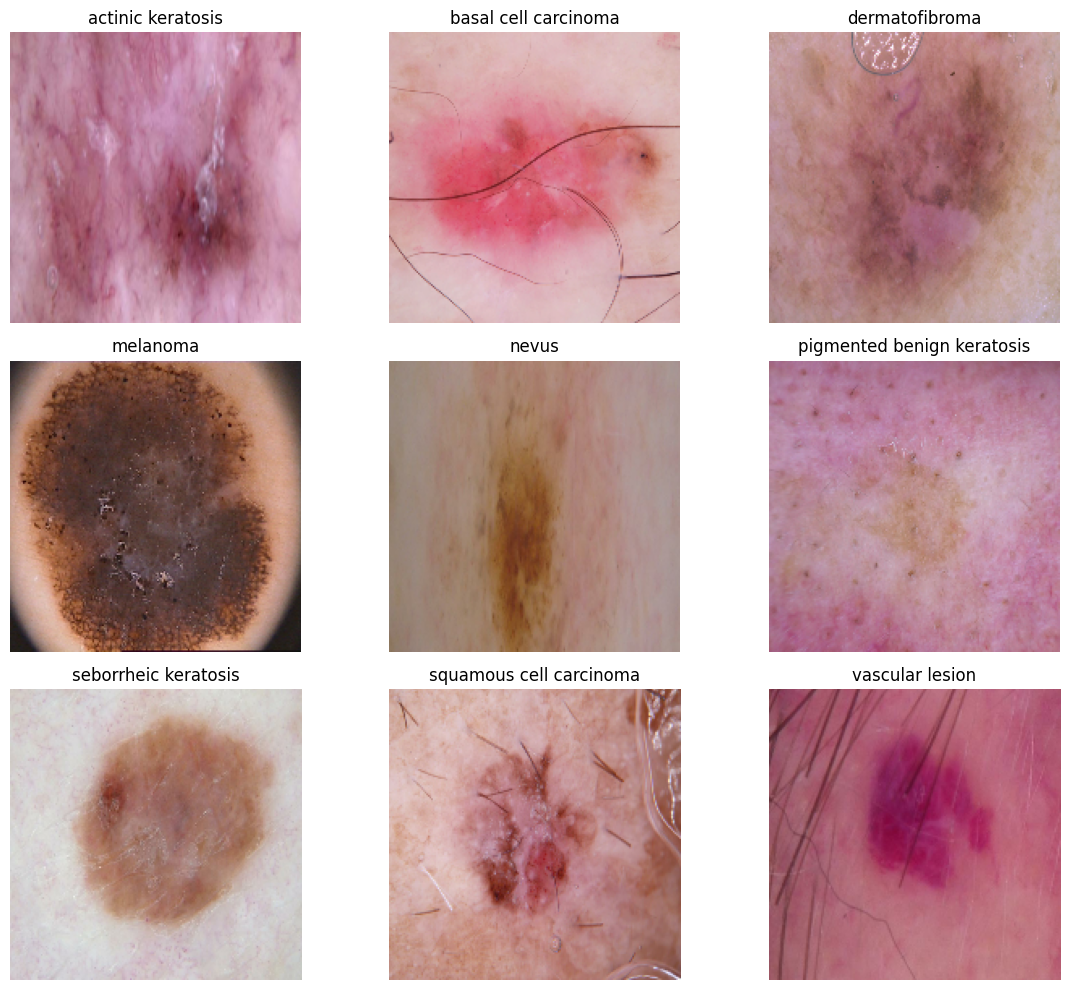

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
    for i in range(len(class_names)):
        ax = plt.subplot(3, 3, i + 1)
        mask = labels.numpy() == i
        img = images.numpy()[mask][0]
        plt.imshow(img.astype('uint8'))
        plt.title(class_names[i])
        plt.axis('off')
plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Build & Train Initial CNN

In [13]:
# Model Definition

num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=img_size + (3,)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

/Users/abdulraafay/Projects/py_projs/py310/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# Compile the model with proper hyperparameters & check the model architecture

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Train the model (without any augmentation or balancing classes)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.1658 - loss: 2.1305 - val_accuracy: 0.2174 - val_loss: 1.8759
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.3909 - loss: 1.5918 - val_accuracy: 0.3043 - val_loss: 2.1545
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.4428 - loss: 1.4952 - val_accuracy: 0.2609 - val_loss: 2.4861
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.4582 - loss: 1.4072 - val_accuracy: 0.2609 - val_loss: 2.4874
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5427 - loss: 1.2312 - val_accuracy: 0.3043 - val_loss: 2.6327
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5739 - loss: 1.1730 - val_accuracy: 0.2609 - val_loss: 3.4509
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6130 - loss: 1.0508 - val_accuracy: 0.1739 - val_loss: 3.8352
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6280 - loss: 0.9899 - val_accu

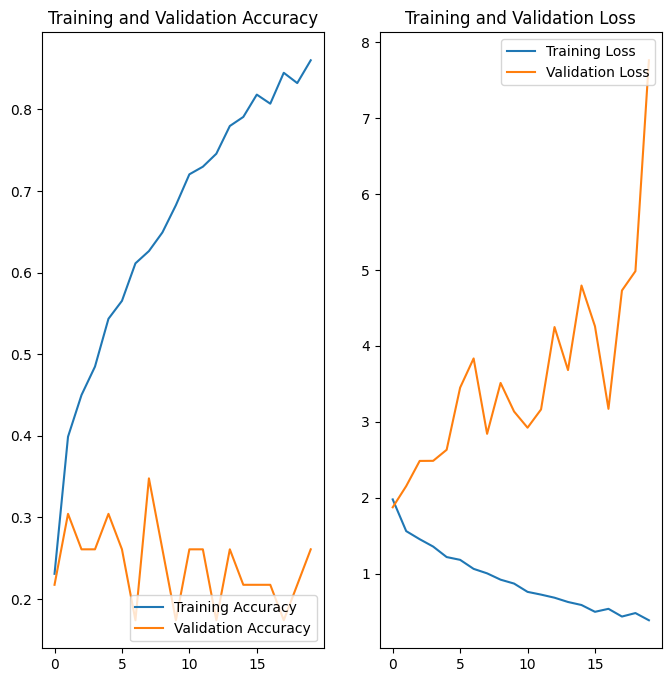

In [35]:
# Visualize Training Results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 20
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

## Findings as follows -

> 1. The model is clearly overfitting on training data - Training accuracy is increasing & Validation accuracy has no significant change
> 2. Class imbalance and less number of images could be the cause
> 3. Augmentation may help in decreasing validation loss

## 5. Data Augmentation

In [36]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

augmented_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=img_size + (3,)),
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

augmented_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

aug_history = augmented_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20)

Epoch 1/20


/Users/abdulraafay/Projects/py_projs/py310/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.1945 - loss: 2.0633 - val_accuracy: 0.2174 - val_loss: 2.5462
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.3793 - loss: 1.5949 - val_accuracy: 0.3043 - val_loss: 1.8773
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.4334 - loss: 1.4731 - val_accuracy: 0.2609 - val_loss: 2.1411
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.4455 - loss: 1.3958 - val_accuracy: 0.3043 - val_loss: 2.0863
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.4888 - loss: 1.3935 - val_accuracy: 0.3478 - val_loss: 1.9656
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.4657 - loss: 1.3658 - val_accuracy: 0.3478 - val_loss: 1.7803
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.4798 - loss: 1.3377 - val_accuracy: 0.3913 - val_loss: 1.6711
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5011 - loss: 1.2591 - val_accuracy: 0.217

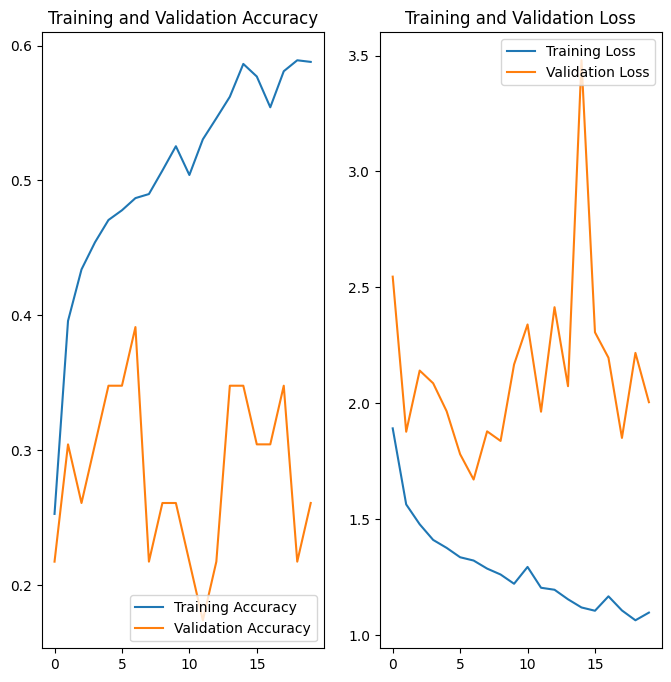

In [37]:
# Visualize Training Results

acc = aug_history.history['accuracy']
val_acc = aug_history.history['val_accuracy']

loss = aug_history.history['loss']
val_loss = aug_history.history['val_loss']
epochs = 20
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. Class Distribution

In [12]:
import pandas as pd

counts = {cls: len(list((train_data_dir/cls).glob('*.*'))) for cls in class_names}
dist_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
dist_df = dist_df.sort_values('count')
display(dist_df)
print('Least samples:', dist_df.index[0], dist_df.iloc[0,0])
print('Most samples:', dist_df.index[-1], dist_df.iloc[-1,0])

,count
seborrheic keratosis,77
dermatofibroma,95
actinic keratosis,114
vascular lesion,139
squamous cell carcinoma,181
nevus,357
basal cell carcinoma,376
melanoma,438
pigmented benign keratosis,462


Least samples: seborrheic keratosis 77
Most samples: pigmented benign keratosis 462


## 7. Handle Class Imbalance with Augmentor

In [13]:
!pip install Augmentor


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import Augmentor

balanced_dir = pathlib.Path('./augmented_data_v3')
balanced_dir.mkdir(exist_ok=True)

max_count = dist_df['count'].max()
for cls, cnt in counts.items():
    src = train_data_dir / cls
    dst = balanced_dir / cls
    dst.mkdir(parents=True, exist_ok=True)
    for img_path in src.glob('*.*'):
        (dst / img_path.name).write_bytes(img_path.read_bytes())
    if cnt < max_count:
        p = Augmentor.Pipeline(source_directory=str(src),
                               output_directory=str(dst))
        p.flip_left_right(probability=0.5)
        p.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
        p.zoom_random(probability=0.5, percentage_area=0.8)
        p.sample(max_count - cnt)

## 8. Train Final Model on Balanced Data

In [44]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 1.0 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.12.2 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [25]:
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [28]:
train_bal_ds = tf.keras.utils.image_dataset_from_directory(
    balanced_dir,
    validation_split=0.2,
    subset='training',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size)

val_bal_ds = tf.keras.utils.image_dataset_from_directory(
    balanced_dir,
    validation_split=0.2,
    subset='validation',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size)

# 1) Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# 2) Build the model (Sequential style)
final_model = tf.keras.Sequential([
    # normalize + augment
    layers.Rescaling(1./255, input_shape=img_size + (3,)),
    data_augmentation,

    # — Block 1 —
    layers.Conv2D(64, 3, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),

    # — Block 2 —
    layers.Conv2D(128, 3, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),

    # — Block 3 —
    layers.Conv2D(256, 3, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    # — Block 4 —
    layers.Conv2D(512, 3, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    # — Block 5 —
    layers.Conv2D(1024, 3, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    # head
    layers.GlobalAveragePooling2D(),
    layers.Dense(256,
                 activation='relu',
                 kernel_regularizer=regularizers.l2(1e-6)),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# 3) LR schedule & optimizer
steps_per_epoch = tf.data.experimental.cardinality(train_bal_ds).numpy()
total_steps = steps_per_epoch * 30

lr_schedule = CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=total_steps,
    alpha=1e-6 / 1e-3
)

opt = AdamW(weight_decay=1e-5, learning_rate=lr_schedule)

# 4) Compile
final_model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# 5) Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

final_history = final_model.fit(
    train_bal_ds,
    validation_data=val_bal_ds,
    epochs=30)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Epoch 1/30


/Users/abdulraafay/Projects/py_projs/py310/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 218ms/step - accuracy: 0.3028 - loss: 2.2730 - val_accuracy: 0.1499 - val_loss: 2.7319
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.4140 - loss: 1.6292 - val_accuracy: 0.1499 - val_loss: 2.6721
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - accuracy: 0.4403 - loss: 1.5612 - val_accuracy: 0.1499 - val_loss: 2.7128
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.4555 - loss: 1.4433 - val_accuracy: 0.1499 - val_loss: 3.3430
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.4871 - loss: 1.4691 - val_accuracy: 0.1499 - val_loss: 3.1032
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.4689 - loss: 1.4541 - val_accuracy: 0.1566 - val_loss: 2.4774
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.4987 - loss: 1.3969 - val_accuracy: 0.1857 - val_loss: 2.3321
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 0.5055 - loss: 1.3504 - val_accuracy: 0.304

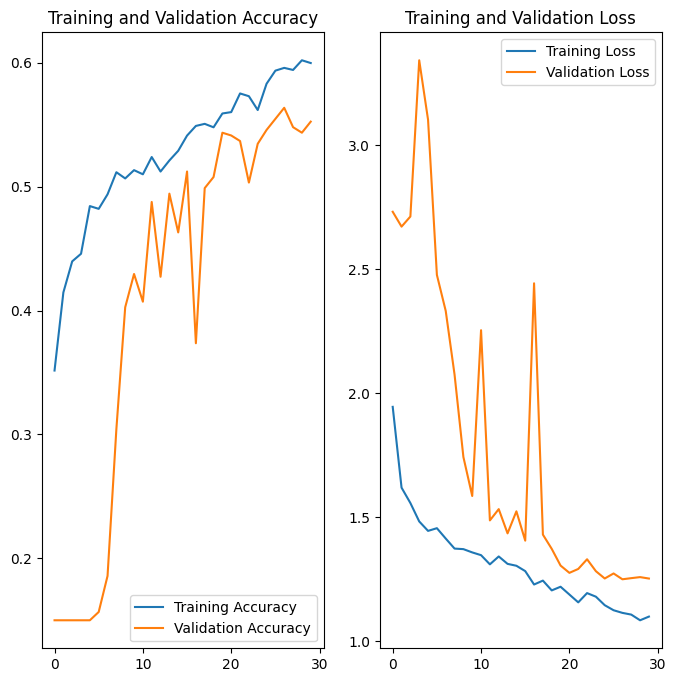

In [30]:
acc = final_history.history['accuracy']
val_acc = final_history.history['val_accuracy']

loss = final_history.history['loss']
val_loss = final_history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4221 - loss: 2.0941
Test   →  Loss: 2.0117,  Accuracy: 0.4068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


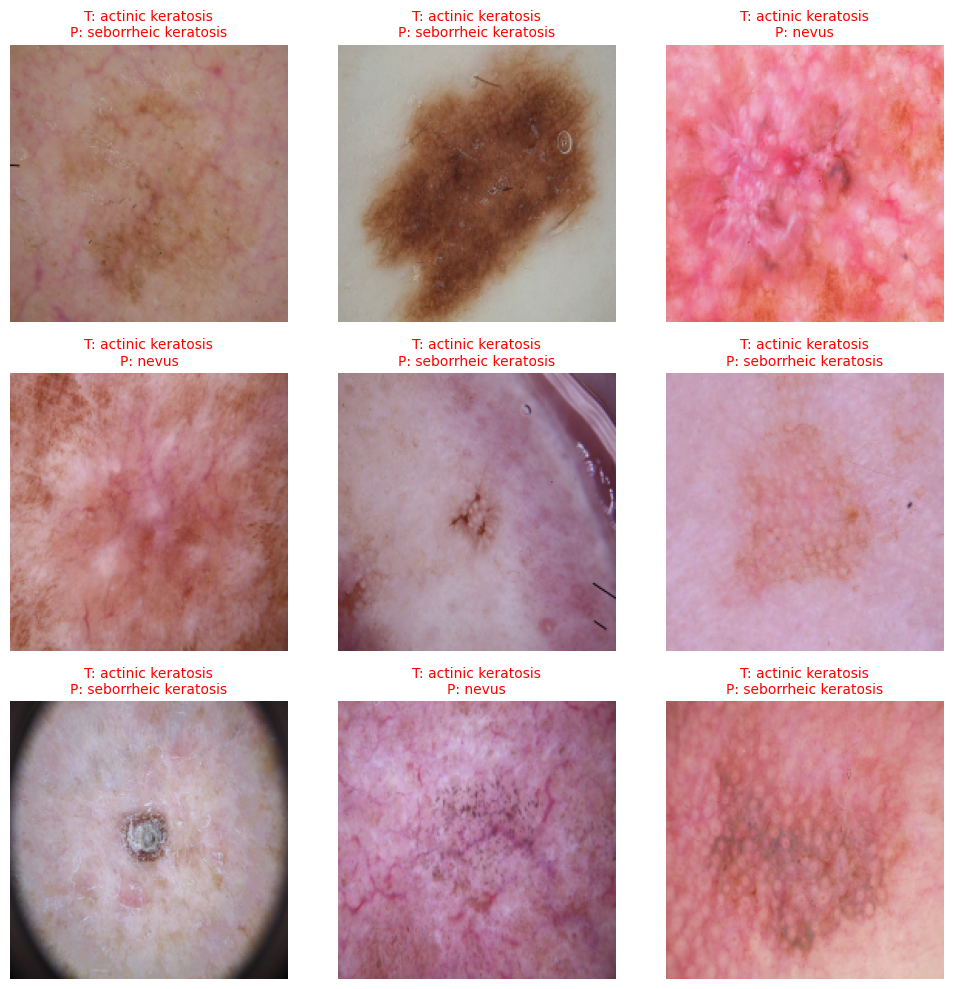

In [35]:
test_dir = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Test')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False  # important so labels stay in order
)

# 2) Evaluate on the test set
test_loss, test_acc = final_model.evaluate(test_ds)
print(f"Test   →  Loss: {test_loss:.4f},  Accuracy: {test_acc:.4f}")

# 3) Gather predictions & true labels
y_true = []
y_pred = []

for batch_imgs, batch_labels in test_ds:
    preds = model.predict(batch_imgs)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# 5) Display a few examples with T/P labels
plt.figure(figsize=(10,10))
for i, (img, true_lbl) in enumerate(test_ds.unbatch().take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(img.numpy().astype("uint8"))
    true_name = class_names[true_lbl.numpy()]
    pred_name = class_names[ y_pred[i] ]
    color = "green" if true_name==pred_name else "red"
    ax.set_title(f"T: {true_name}\nP: {pred_name}", color=color, fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Final Observations:

> 1. Training accuracy: 0.5992, Training Loss: 1.0878, Validation Accuracy: 0.5526, Validation Loss: 1.2526 after 30 epochs (augmentation + data balancing applied) 
> 2. Test Accuracy: 0.421
> 3. After applying augmentation & balancing dataset across different classes, I can see that the model didnt overfit to the previous extent, but was still overfitting
> 4. Model starts underfitting (when I start managing its overfitting issue) by reducing learning rate and by adding dropout & Global Average Pooling layers
> 5. After various trainings for 30 epochs, I conclude that we will need transfer learning approach to fit the model better to the small dataset